In [1]:
import torch
import numpy as np
import matplotlib as plt
import torch.nn.functional as F

# Define the file path to save/load the data
save_path = 'pet_ct_dataset_2_tensor.pt'
data = torch.load(save_path, map_location='cpu', weights_only=False)

# Read each data item based on keys
# pet_images = data['pet_images_clean']
ct_images = data['ct_images_clean']
# pet_sinograms_clean = data['pet_sinograms_clean']
ct_sinograms_clean = data['ct_sinograms_clean']
# pet_sinograms_noised = data['pet_sinograms_noised']
# ct_sinograms_noised = data['ct_sinograms_noised']

print(f"Loaded {len(ct_images)} images.")


Loaded 2000 images.


In [2]:
def compute_bowsher_kernel_2d_torch(image_2d, device, zeta=0.5, rho=0.01, epsilon=1e-6, alpha=0.001):
    """
    Compute a 2D Bowsher-like kernel using PyTorch vectorized operations with GPU acceleration support.
    
    Parameters:
    - image_2d: numpy array with shape (H, W)
    - device: device selection, 'cuda' or 'cpu'
    - zeta, rho, epsilon, alpha: computation parameters, consistent with the original function
    
    Returns:
    - kernel: computed kernel returned as a numpy array with shape (H, W)
    """
    # Convert to PyTorch tensor and send to the specified device
    image = image_2d.clone().detach().to(device)
    # image = torch.tensor(image_2d, dtype=torch.float32, device=device)
    # The Tq operation here is an identity mapping
    transformed = image

    # Add batch and channel dimensions, changing the shape to (1, 1, H, W)
    transformed = transformed.unsqueeze(0).unsqueeze(0)
    
    # Apply padding (replicating edges) to ensure boundary pixels can also extract 3x3 neighborhoods
    padded = F.pad(transformed, (1, 1, 1, 1), mode='replicate')
    
    # Use unfold to extract 3x3 neighborhoods, resulting in shape (1, 9, H*W)
    patches = F.unfold(padded, kernel_size=3)
    # Reshape to (1, 9, H, W)
    patches = patches.view(1, 9, transformed.shape[-2], transformed.shape[-1])
    
    # Extract the center pixel (located at the 5th position after unfolding, index 4)
    central = patches[:, 4, :, :]  # Shape (1, H, W)
    
    # Extract 8 neighboring pixels (excluding the center)
    neighbors = torch.cat([patches[:, :4, :, :], patches[:, 5:, :, :]], dim=1)  # Shape (1, 8, H, W)
    
    # Compute the absolute difference between the center and its neighbors
    diffs = torch.abs(neighbors - central.unsqueeze(1))
    
    # Compute the maximum difference M_array within each pixel's neighborhood, shape (1, H, W)
    M_array = diffs.max(dim=1)[0]
    
    # Compute the M value for each neighbor using torch.roll to shift the neighborhood
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               ( 0, -1),          ( 0, 1),
               ( 1, -1), ( 1, 0), ( 1, 1)]
    
    neighbor_M = []
    for dy, dx in offsets:
        shifted = torch.roll(M_array, shifts=(dy, dx), dims=(1, 2))
        neighbor_M.append(shifted)
    neighbor_M = torch.stack(neighbor_M, dim=1)  # Shape (1, 8, H, W)
    
    # Compute the average M value: denom = (M_array + neighbor_M) / 2, avoiding division by zero
    denom = (M_array.unsqueeze(1) + neighbor_M) / 2.0
    denom = torch.where(denom > epsilon, denom, torch.full_like(denom, epsilon))
    
    # Compute the normalized difference u_jk
    u_jk = diffs / denom
    
    # Compute psi(u) = (1/pi)*arctan((zeta - u)/rho) + 0.5
    psi_values = 1 - ( (torch.atan((zeta - u_jk) / rho) / torch.pi) + 0.5 )
    
    # Sum over all 8 neighboring psi values, then apply the exponential transformation to get the final kernel
    kernel = psi_values.sum(dim=1)
    # kernel = torch.exp(alpha * kernel)
    
    # Remove the batch dimension and convert back to a numpy array for return
    return kernel.squeeze(0).cpu().numpy()


In [3]:
import gc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

n_samples = len(ct_images)
ct_images_kernel = [None] * n_samples
ct_sinograms_kernel = [None] * n_samples

for i in range(n_samples):
    kernel_img = compute_bowsher_kernel_2d_torch(ct_images[i], device)
    kernel_sino = compute_bowsher_kernel_2d_torch(ct_sinograms_clean[i], device)
    
    ct_images_kernel[i] = kernel_img
    ct_sinograms_kernel[i] = kernel_sino
    
    # Save the data and release memory every 500 processed samples
    if (i+1) % 500 == 0 and (i+1) > 0:
        print(f"Processed {i+1}/{n_samples} samples, updating file...")
        data['ct_images_kernel'] = ct_images_kernel
        data['ct_sinograms_kernel'] = ct_sinograms_kernel
        torch.save(data, save_path)
        
        # Release GPU memory (if using GPU)
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        # Call garbage collection to free unused CPU memory
        gc.collect()

# Save the data one final time
data['ct_images_kernel'] = ct_images_kernel
data['ct_sinograms_kernel'] = ct_sinograms_kernel
torch.save(data, save_path)
print(f"Updated dataset with new kernels has been saved to: {save_path}")


Using device: cuda
Processed 500/2000 samples, updating file...
Processed 1000/2000 samples, updating file...
Processed 1500/2000 samples, updating file...
Processed 2000/2000 samples, updating file...
Updated dataset with new kernels has been saved to: pet_ct_dataset_2_tensor.pt


In [1]:
import odl
import cupy as cp
import numpy as np
import torch
import gc

print("ODL version:", odl.__version__)

# ---------------------------
# Set parameters for the projection operator
# ---------------------------
imageSize = 128
reco_space = odl.uniform_discr(
    min_pt=[-30, -30], max_pt=[30, 30], shape=[imageSize, imageSize], dtype='float32'
)
angle_partition = odl.uniform_partition(0, np.pi, 512)
detector_partition = odl.uniform_partition(-30, 30, 512)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

# ---------------------------
# Load the data dictionary (assuming the data is saved in tensor format or numpy arrays)
# ---------------------------
save_path = "pet_ct_dataset_2_tensor.pt"  # Set according to actual data path
data = torch.load(save_path, map_location="cpu", weights_only=False)

# Retrieve ct_images_kernel from the data dictionary (assuming each element is a numpy array of size (128,128))
ct_images_kernel = data['ct_images_kernel']
n_samples = len(ct_images_kernel)
print(f"Computing ct_images_kernel_sino for {n_samples} samples.")

# Initialize a list to store the projection results
ct_images_kernel_sino = [None] * n_samples

# ---------------------------
# Iterate through all samples and compute projections for each kernel image
# ---------------------------
for i in range(n_samples):
    # Convert the numpy array to a cupy array
    img_cupy = cp.asarray(ct_images_kernel[i])
    # Since ODL's operator does not support implicit conversion of cupy arrays,
    # explicitly call .get() to convert the cupy array to a numpy array
    img_npy = img_cupy.get()
    # Create an ODL element and compute the projection
    img_odl = reco_space.element(img_npy)
    sino_odl = ray_trafo(img_odl)
    # Convert the result to a numpy array for storage
    ct_images_kernel_sino[i] = np.array(sino_odl)
    
    # Update the data dictionary and save every 500 processed samples, while also releasing memory
    if (i+1) % 500 == 0 and (i+1) > 0:
        print(f"Processed {(i+1)}/{n_samples} samples for ct_images_kernel_sino, updating file...")
        data['ct_images_kernel_to_sino'] = ct_images_kernel_sino
        torch.save(data, save_path)
        
        # Release cupy memory
        cp.get_default_memory_pool().free_all_blocks()
        # Release CPU memory
        gc.collect()

# Final update of the data dictionary and save to the same file
data['ct_images_kernel_to_sino'] = ct_images_kernel_sino
torch.save(data, save_path)
print(f"Updated dataset with new ct_images_kernel_to_sino saved to: {save_path}")


ODL version: 1.0.0.dev0
Computing ct_images_kernel_sino for 2000 samples.
Processed 500/2000 samples for ct_images_kernel_sino, updating file...
Processed 1000/2000 samples for ct_images_kernel_sino, updating file...
Processed 1500/2000 samples for ct_images_kernel_sino, updating file...
Processed 2000/2000 samples for ct_images_kernel_sino, updating file...
Updated dataset with new ct_images_kernel_to_sino saved to: pet_ct_dataset_2_tensor.pt


PET Image size: torch.Size([128, 128])
CT Image size: torch.Size([128, 128])
Clean PET Sinogram size: torch.Size([512, 512])
Clean CT Sinogram size: torch.Size([512, 512])
Processed PET Sinogram size: torch.Size([512, 512])
Processed CT Sinogram size: torch.Size([512, 512])
CT Images Kernel size: torch.Size([128, 128])
CT Sinograms Kernel size: torch.Size([512, 512])
CT Images Kernel in Sino size: torch.Size([512, 512])


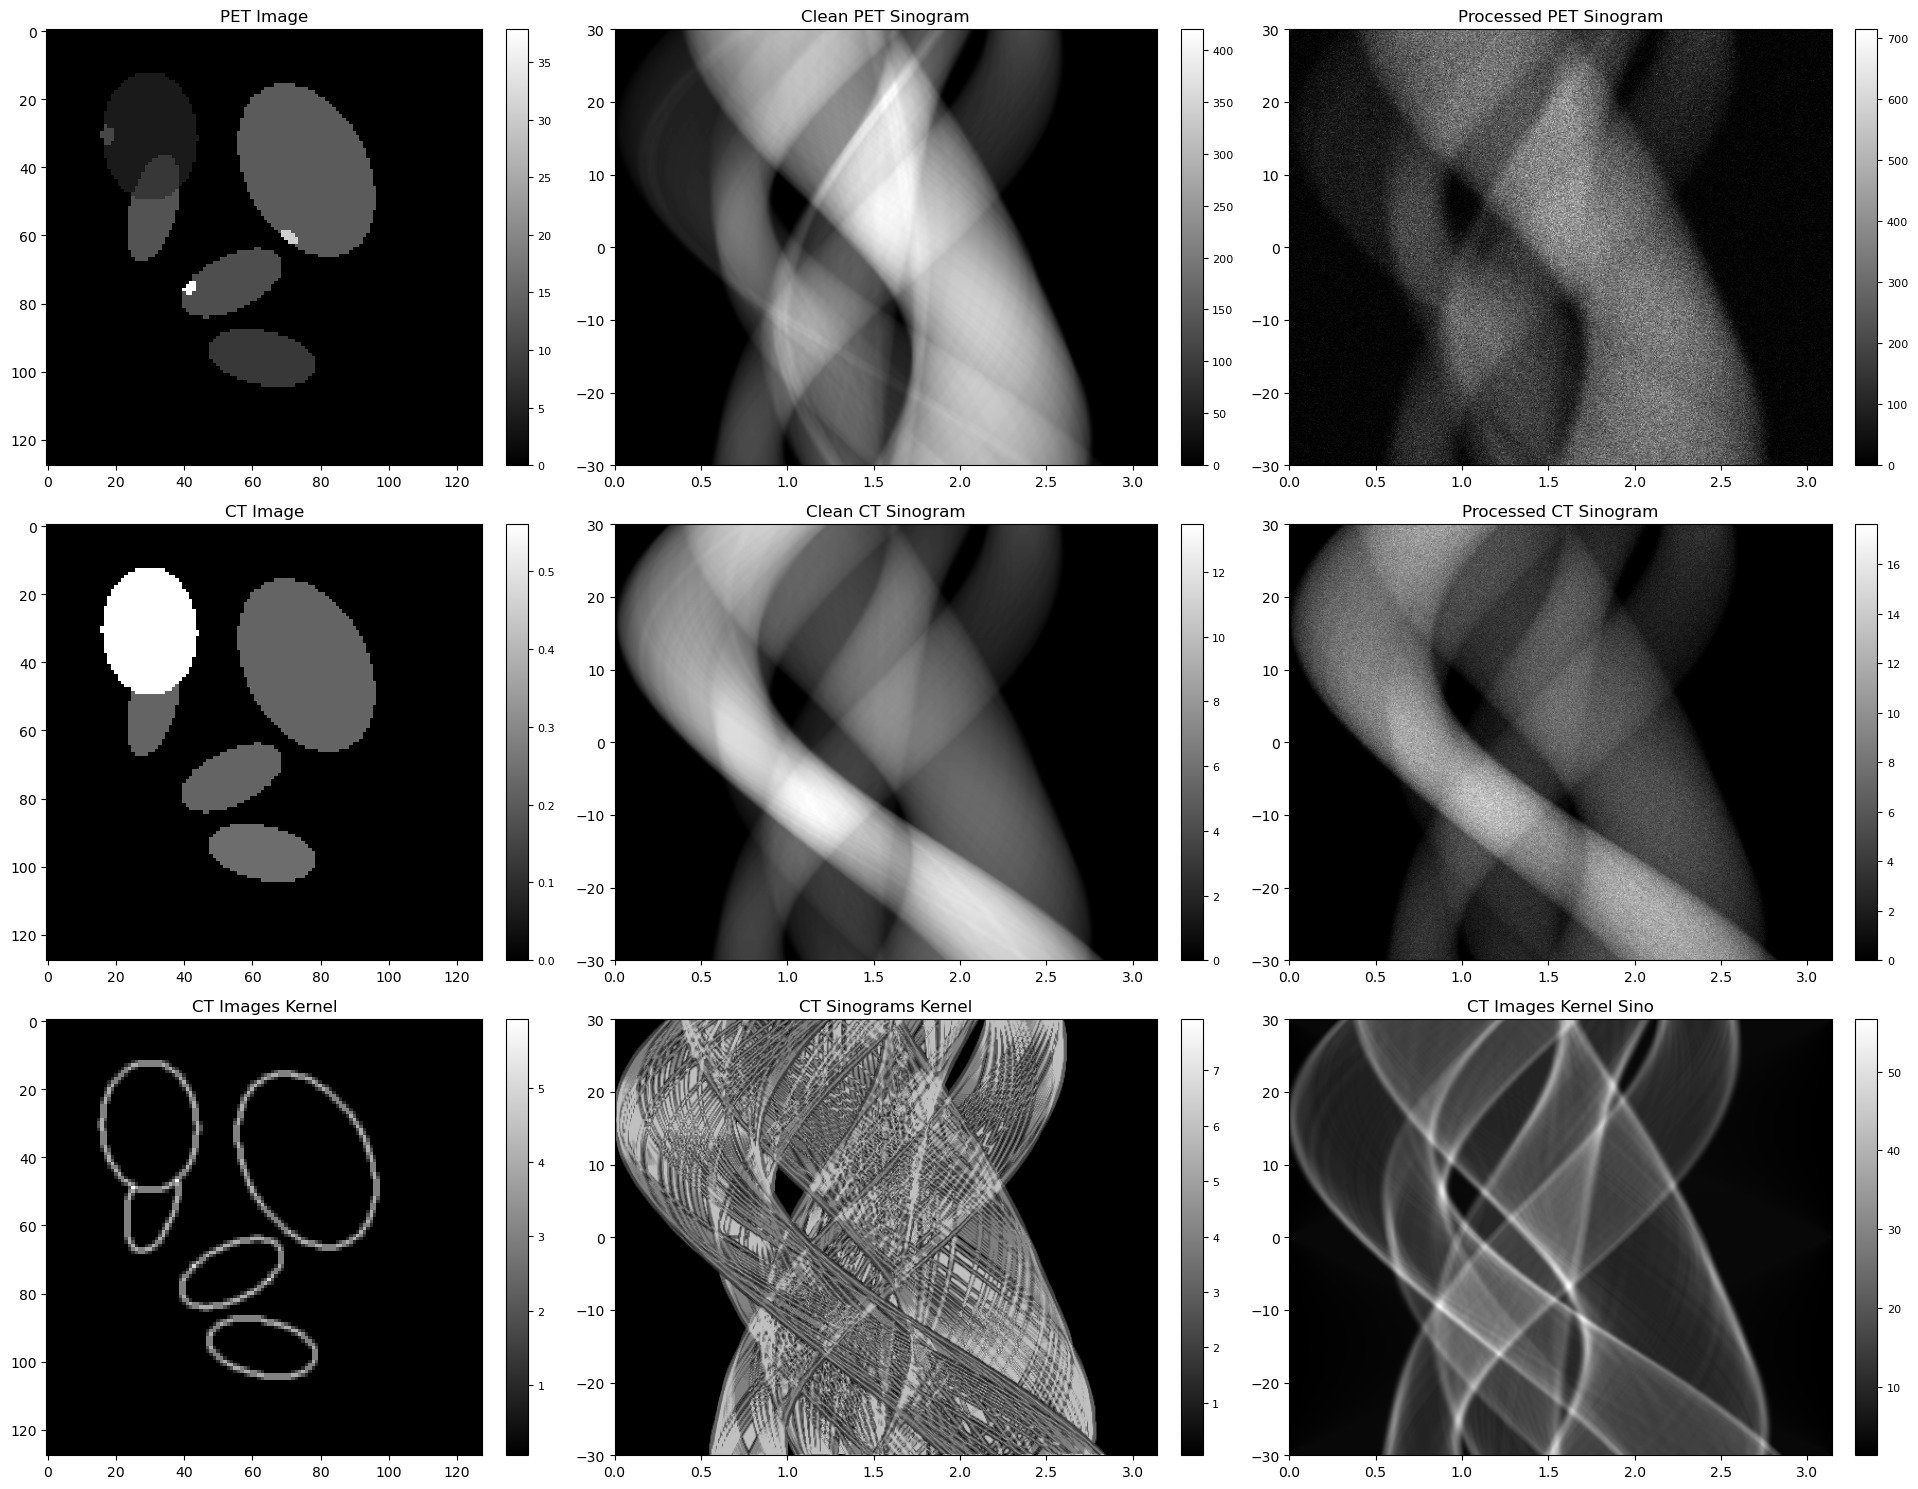

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

dataset_file = "pet_ct_dataset_1_tensor.pt"
data = torch.load(dataset_file, map_location="cpu", weights_only=False)

# Extract the 50th sample from the dataset
sample_index = 50
pet_images             = data['pet_images_clean'][sample_index]
ct_images              = data['ct_images_clean'][sample_index]
pet_sinograms_clean    = data['pet_sinograms_clean'][sample_index]
ct_sinograms_clean     = data['ct_sinograms_clean'][sample_index]
pet_sinograms_noisy    = data['pet_sinograms_noised'][sample_index]
ct_sinograms_noisy     = data['ct_sinograms_noised'][sample_index]
ct_images_kernel       = data['ct_images_kernel'][sample_index]
ct_sinograms_kernel    = data['ct_sinograms_kernel'][sample_index]
ct_images_kernel_to_sino  = data['ct_images_kernel_to_sino'][sample_index]

# Print the shape of each image
print("PET Image size:", pet_images.shape)
print("CT Image size:", ct_images.shape)
print("Clean PET Sinogram size:", pet_sinograms_clean.shape)
print("Clean CT Sinogram size:", ct_sinograms_clean.shape)
print("Processed PET Sinogram size:", pet_sinograms_noisy.shape)
print("Processed CT Sinogram size:", ct_sinograms_noisy.shape)
print("CT Images Kernel size:", ct_images_kernel.shape)
print("CT Sinograms Kernel size:", ct_sinograms_kernel.shape)
print("CT Images Kernel in Sino size:", ct_images_kernel_to_sino.shape)

# Create a 3-row, 3-column subplot grid
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

# Define a function to add colorbars
def add_colorbar(im, ax_obj):
    cbar = fig.colorbar(im, ax=ax_obj, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# First row: PET-related images
im0 = ax[0, 0].imshow(pet_images, cmap="gray")
ax[0, 0].set_title("PET Image")
add_colorbar(im0, ax[0, 0])

im1 = ax[0, 1].imshow(pet_sinograms_clean, cmap="gray", aspect="auto", extent=[0, np.pi, -30, 30])
ax[0, 1].set_title("Clean PET Sinogram")
add_colorbar(im1, ax[0, 1])

im2 = ax[0, 2].imshow(pet_sinograms_noisy, cmap="gray", aspect="auto", extent=[0, np.pi, -30, 30])
ax[0, 2].set_title("Processed PET Sinogram")
add_colorbar(im2, ax[0, 2])

# Second row: CT original images and sinograms
im3 = ax[1, 0].imshow(ct_images, cmap="gray")
ax[1, 0].set_title("CT Image")
add_colorbar(im3, ax[1, 0])

im4 = ax[1, 1].imshow(ct_sinograms_clean, cmap="gray", aspect="auto", extent=[0, np.pi, -30, 30])
ax[1, 1].set_title("Clean CT Sinogram")
add_colorbar(im4, ax[1, 1])

im5 = ax[1, 2].imshow(ct_sinograms_noisy, cmap="gray", aspect="auto", extent=[0, np.pi, -30, 30])
ax[1, 2].set_title("Processed CT Sinogram")
add_colorbar(im5, ax[1, 2])

# Third row: Newly computed kernel structures
im6 = ax[2, 0].imshow(ct_images_kernel, cmap="gray")
ax[2, 0].set_title("CT Images Kernel")
add_colorbar(im6, ax[2, 0])

im7 = ax[2, 1].imshow(ct_sinograms_kernel, cmap="gray", aspect="auto", extent=[0, np.pi, -30, 30])
ax[2, 1].set_title("CT Sinograms Kernel")
add_colorbar(im7, ax[2, 1])

im8 = ax[2, 2].imshow(ct_images_kernel_to_sino, cmap="gray", aspect="auto", extent=[0, np.pi, -30, 30])
ax[2, 2].set_title("CT Images Kernel Sino")
add_colorbar(im8, ax[2, 2])

plt.tight_layout()
plt.show()


In [1]:
import torch

dataset_file = "pet_ct_dataset_5_tensor.pt"
data = torch.load(dataset_file, map_location="cpu", weights_only=False)

# Define the list of keys of interest (each key corresponds to a list)
keys = [
    'pet_images_clean',
    'ct_images_clean',
    'pet_sinograms_clean',
    'ct_sinograms_clean',
    'pet_sinograms_noised',
    'ct_sinograms_noised',
    'ct_images_kernel',
    'ct_sinograms_kernel',
    'ct_images_kernel_to_sino'
]

# Iterate through each key, check if the first element is a Tensor
# If not, convert the entire list to Tensors
for key in keys:
    if not torch.is_tensor(data[key][0]):
        print(f"Key '{key}' first element is not a tensor, converting all elements...")
        data[key] = [torch.tensor(elem) for elem in data[key]]
    else:
        print(f"Key '{key}' first element is already a tensor, skipping conversion.")

# Save the converted dataset back to the file
torch.save(data, dataset_file)
print(f"Saved as {dataset_file}")


Key 'pet_images_clean' first element is already a tensor, skipping conversion.
Key 'ct_images_clean' first element is already a tensor, skipping conversion.
Key 'pet_sinograms_clean' first element is already a tensor, skipping conversion.
Key 'ct_sinograms_clean' first element is already a tensor, skipping conversion.
Key 'pet_sinograms_noised' first element is already a tensor, skipping conversion.
Key 'ct_sinograms_noised' first element is already a tensor, skipping conversion.
Key 'ct_images_kernel' first element is not tensor, converting all elements...
Key 'ct_sinograms_kernel' first element is not tensor, converting all elements...
Key 'ct_images_kernel_to_sino' first element is not tensor, converting all elements...
Saved as pet_ct_dataset_5_tensor.pt


In [8]:
import torch

dataset_file = "pet_ct_dataset_1_tensor.pt"

# Load the dataset file
data = torch.load(dataset_file, map_location="cpu", weights_only=False)

# Specify the key to delete
key_to_delete = 'ct_images_kernel_to_sino'
if key_to_delete in data:
    del data[key_to_delete]
    print(f"Deleted '{key_to_delete}'.")
else:
    print(f"Key '{key_to_delete}' not found, no deletion needed.")

# Save the modified dataset back to the file
torch.save(data, dataset_file)
print(f"Saved as {dataset_file}")


Have deleted 'ct_images_kernel_to_sino'。
Saved as pet_ct_dataset_1_tensor.pt
